<a href="https://www.kaggle.com/code/aisuko/document-question-answering?scriptVersionId=164851849" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Document Question Answering, also referred to as Document Visual Question Answering, is a task that involes providing answers to questions posed about document images. The input to models supporting this task is typically a combination of an image and s question, and the output is an answer expressed in natural language. These models utilize multiple modalities, including text, the positions of words(bounding boxes), and the image itself. Here we are going to fine-tune a LLLM [Multi-model Pre-training for Visually-Rich Document Understanding](https://arxiv.org/abs/2012.14740) on the `document-question-answering` dataset. All the models in `LayoutLM*` architectures can be supported.

In [1]:
%%capture
!pip install transformers==4.35.2
!pip install datasets==2.15.0
!pip install evaluate==0.4.1
# Seqeval is useful for evaluation metrics such as F1 sequence labeling tasks.
!pip install seqeval==1.2.2

In [2]:
import os
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

os.environ["WANDB_API_KEY"]=user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_PROJECT"] = "Fine-tuning ms-layoutlm-v3"
os.environ["WANDB_NAME"] = "ft-ms-layoutlmv3-funsd-layoutlmv3"

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Load the data

We will use a small sample of preprocessed DocVQA in here.

In [3]:
from datasets import load_dataset

dataset=load_dataset("aisuko/funsd-layoutlmv3")
dataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 50
    })
})

In [4]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None)}

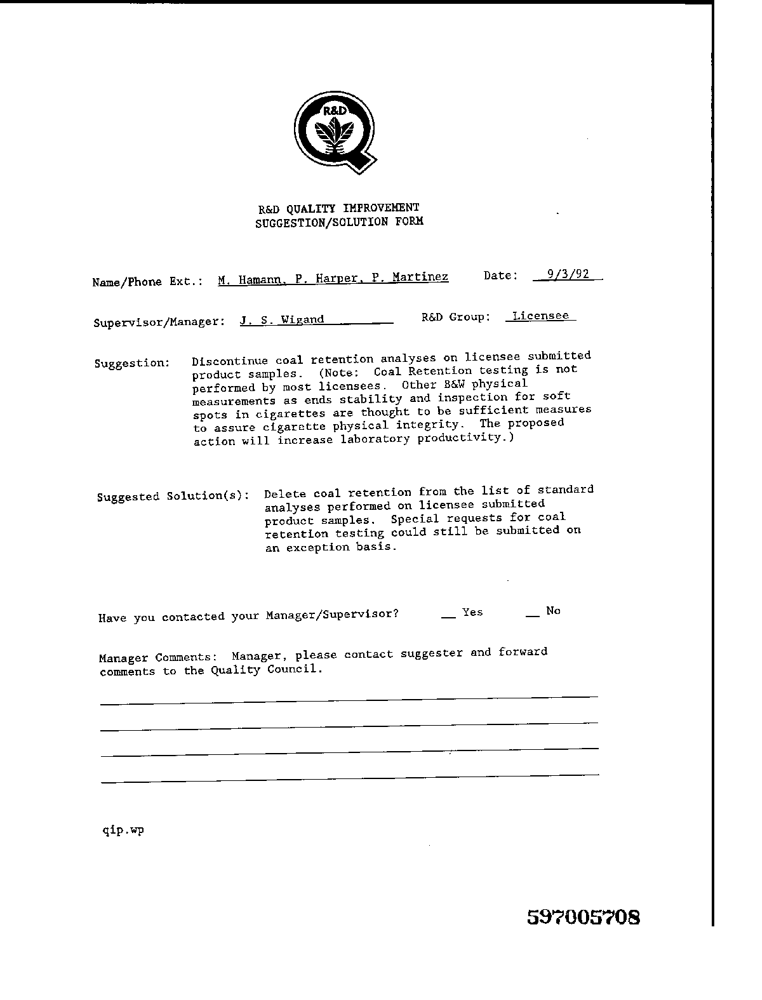

In [5]:
example=dataset["train"][0]
example["image"]

In [6]:
words, boxes, ner_tags=example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['R&D', ':', 'Suggestion:', 'Date:', 'Licensee', 'Yes', 'No', '597005708', 'R&D', 'QUALITY', 'IMPROVEMENT', 'SUGGESTION/', 'SOLUTION', 'FORM', 'Name', '/', 'Phone', 'Ext.', ':', 'M.', 'Hamann', 'P.', 'Harper,', 'P.', 'Martinez', '9/', '3/', '92', 'R&D', 'Group:', 'J.', 'S.', 'Wigand', 'Supervisor', '/', 'Manager', 'Discontinue', 'coal', 'retention', 'analyses', 'on', 'licensee', 'submitted', 'product', 'samples', '(Note', ':', 'Coal', 'Retention', 'testing', 'is', 'not', 'performed', 'by', 'most', 'licensees.', 'Other', 'B&W', 'physical', 'measurements', 'as', 'ends', 'stability', 'and', 'inspection', 'for', 'soft', 'spots', 'in', 'ciparettes', 'are', 'thought', 'to', 'be', 'sufficient', 'measures', 'to', 'assure', 'cigarette', 'physical', 'integrity.', 'The', 'proposed', 'action', 'will', 'increase', 'laboratory', 'productivity', '.', ')', 'Suggested', 'Solutions', '(s)', ':', 'Delete', 'coal', 'retention', 'from', 'the', 'list', 'of', 'standard', 'analyses', 'performed', 'on', 'licen

# Preparing

Here we prepare the dataset for the model by using `LayoutLMv3Processor`. It internally wraps a `LayoutLMv3FeatureExtractor` for the image modality and a `LayoutLMv3Tokenizer` for the text modality into one. Basically, the processor does the following internally:

- the feature extractor is used to resize+normalize each document image into `pixel_values`
- the tokenizer is ued to turn the words, boxes and NER tags into token-level
  - `input_ids`
  - `attention_mask`
  - `labels`

In [7]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor=AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
print(processor)

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

LayoutLMv3Processor:
- image_processor: LayoutLMv3ImageProcessor {
  "apply_ocr": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "LayoutLMv3FeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "LayoutLMv3ImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "ocr_lang": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

- tokenizer: LayoutLMv3TokenizerFast(name_or_path='microsoft/layoutlmv3-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, 

We'll first create `idlabel` and `label2id` mappings, useful for inference.
Note: that `LayoutLMv3ForTokenClassification` (the model we will use later on) will simply output an integer index for a particular class (for each token), so we still need to map it to an actual class name.

In [8]:
from datasets.features import ClassLabel

features=dataset["train"].features
column_names=dataset["train"].column_names
image_column_name="image"
text_column_name="tokens"
boxes_column_name="bboxes"
label_column_name="ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the unique labels.
def get_label_list(labels):
    unique_labels=set()
    for label in labels:
        unique_labels=unique_labels|set(label)
    label_list=list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list=features[label_column_name].feature.names
    # No need to convert the labels since they are already ints
    id2label={k: v for k,v in enumerate(label_list)}
    label2id={v: k for k,v in enumerate(label_list)}
else:
    label_list=get_label_list(dataset["train"][label_column_name])
    id2label={k:v for k,v in enumerate(label_list)}
    label2id={v:k for k,v in enumerate(label_list)}

num_labels=len(label_list)
print(num_labels)

7


In [9]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format`(used later on) to work properly
features=Features({
    'pixel_values': Array3D(dtype="float32", shape=(3,224,224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})


def prepare_examples(examples):
    images=examples[image_column_name]
    words=examples[text_column_name]
    boxes=examples[boxes_column_name]
    word_labels=examples[label_column_name]
    encoding=processor(
        images,
        words,
        boxes=boxes,
        word_labels=word_labels,
        truncation=True,
        padding="max_length"
    )
    return encoding

train_dataset=dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

eval_dataset=dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

print(train_dataset)

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 149
})


In [10]:
example=train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette physical integrity. The proposed action will increase laboratory productivity. ) Suggested Solutions (s) : Delete coal retention from the list of standard analyses performed on licensee submitted product samples. Special requests for coal retention testing could still be submitted on an exception basis. Have you contacted your Manager/ Supervisor? Manager Comments: Manager, please contact suggester and forward comments to the Quality Council. qip. wp</s><pad><pad><pad><pad><pad><pad><pad><p

In [11]:
train_dataset.set_format("torch")

Let's verify that everying was created properly:

In [12]:
import torch

example=train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [13]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

"<s> TO: DATE: 3 Fax: NOTE: 82092117 614 -466 -5087 Dec 10 '98 17 :46 P. 01 ATT. GEN. ADMIN. OFFICE Attorney General Betty D. Montgomery CONFIDENTIAL FACSIMILE TRANSMISSION COVER SHEET (614) 466- 5087 FAX NO. George Baroody (336) 335- 7392 FAX NUMBER: PHONE NUMBER: (336) 335- 7363 NUMBER OF PAGES INCLUDING COVER SHEET: June Flynn for Eric Brown/ (614) 466- 8980 SENDER /PHONE NUMBER: SPECIAL INSTRUCTIONS: IF YOU DO NOT RECEIVE ANY OF THE PAGES PROPERLY, PLEASE CONTACT SENDER AS SOON AS POSSIBLE THIS MESSAGE IS INTENDED ONLY FOR THE USE OF THE INDIVIDUAL OR ENTITY TO WHOM IT IS ADDRESSED AND MAY CONTAIN INFORMATION THAT IS PRIVILEGED. CONFIDENTIAL, AND EXEMPT FROM DISCLOSURE UNDER APPLICABLE LAW. If the reader of this message is not the intended recipient of the employee or agent responsible for delivering the message to the intended recipient, you are hereby notified that any dissemination, distribution, copying, or conveying of this communication in any manner is strictly prohibited. I

In [14]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
    print(processor.tokenizer.decode([id]), label.item())

<s> -100
 R 0
& -100
D -100
 : 3
 Suggest 3
ion -100
: -100
 Date 3
: -100
 License 5
e -100
 Yes 3
 No 3
 5 0
97 -100
005 -100
708 -100
 R 1
& -100
D -100
 QU 2
AL -100
ITY -100
 IM 2
PROV -100
EMENT -100
 S 2
UG -100
G -100
EST -100
ION -100
/ -100
 SOL 2
UTION -100
 FORM 2
 Name 3
 / 4
 Phone 4
 Ext 4
. -100
 : 4
 M 5
. -100
 Ham 6
ann -100
 P 6
. -100
 Harper 6
, -100
 P 6
. -100
 Martinez 6
 9 5
/ -100
 3 6
/ -100
 92 6
 R 3
& -100
D -100
 Group 4
: -100
 J 5
. -100
 S 6
. -100
 W 6
ig -100
and -100
 Supervisor 3
 / 4
 Manager 4
 Disc 5
ont -100
in -100
ue -100
 coal 6
 retention 6
 analyses 6
 on 6
 licensee 6
 submitted 6
 product 6
 samples 6
 ( 6
Note -100
 : 6
 Coal 6
 Ret 6
ention -100
 testing 6
 is 6
 not 6
 performed 6
 by 6
 most 6
 license 6
es -100
. -100
 Other 6
 B 6
& -100
W -100
 physical 6
 measurements 6
 as 6
 ends 6
 stability 6
 and 6
 inspection 6
 for 6
 soft 6
 spots 6
 in 6
 c 6
ip -100
arettes -100
 are 6
 thought 6
 to 6
 be 6
 sufficient 6
 measures 6
 

# Define metrics

Let's define a `compute_metrics` function, which is used by the Trainer.

In [15]:
import numpy as np
import evaluate

return_entity_level_metrics=False
metric=evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels=p
    predictions=np.argmax(predictions, axis=2)
    
    # Remove ignored index (special tokens)
    true_predictions=[
        [label_list[p] for (p,l) in zip(prediction, label) if l!=-100]
        for prediction, label in zip(predictions, labels)
    ]
    
    true_labels=[
        [label_list[l] for (p, l) in zip(prediction, label) if l!=-100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results=metric.compute(predictions=true_predictions, references=true_labels)
    
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results={}
        for key, value in results.items():
            if isinstance(value, dict):
                for n,v in value.items():
                    final_results[f"{key}_{n}"]=v
            else:
                final_results[key]=value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

# Define the model

This is a Transformer encoder with pre-trained weights, and a randomly initialized head on top for token classification.

In [16]:
from transformers import LayoutLMv3ForTokenClassification

model=LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    id2label=id2label,
    label2id=label2id,
)

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from transformers import TrainingArguments, Trainer
from transformers.data.data_collator import default_data_collator


training_args=TrainingArguments(
    output_dir=os.getenv("WANDB_NAME"),
    max_steps=200,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-5,
    evaluation_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="wandb", # or report_to="tensorboard"
    run_name=os.getenv("WANDB_NAME"),
    
)


trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: Currently logged in as: urakiny (causal_language_trainer). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240229_121646-767q98hx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-ms-layoutlmv3-funsd-layoutlmv3
wandb: ⭐️ View project at https://wandb.ai/causal_language_trainer/Fine-tuning%20ms-layoutlm-v3
wandb: 🚀 View run at https://wandb.ai/causal_language_trainer/Fine-tuning%20ms-layoutlm-v3/runs/767q98hx
/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.610365,0.808015,0.861401,0.833854,0.826221
200,No log,0.575469,0.842205,0.880278,0.860821,0.832402


TrainOutput(global_step=200, training_loss=0.6039309692382813, metrics={'train_runtime': 786.7419, 'train_samples_per_second': 4.067, 'train_steps_per_second': 0.254, 'total_flos': 785543922831360.0, 'train_loss': 0.6039309692382813, 'epoch': 20.0})

# Evaluate the model

In [18]:
trainer.evaluate()

{'eval_loss': 0.5754685401916504,
 'eval_precision': 0.8422053231939164,
 'eval_recall': 0.8802781917536016,
 'eval_f1': 0.8608209861549672,
 'eval_accuracy': 0.8324022346368715,
 'eval_runtime': 5.2994,
 'eval_samples_per_second': 9.435,
 'eval_steps_per_second': 0.755,
 'epoch': 20.0}

In [19]:
kwargs={
    'model_name': f'{os.getenv("WANDB_NAME")}',
    'finetuned_from': 'microsoft/layoutlmv3-base',
    'tasks': 'Token Classification',
#     'dataset_tags':'',
    'dataset':'aisuko/funsd-layoutlmv3'
}

processor.push_to_hub(os.getenv("WANDB_NAME"))
trainer.push_to_hub(**kwargs)

training_args.bin:   0%|          | 0.00/4.16k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

'https://huggingface.co/aisuko/ft-ms-layoutlmv3-funsd-layoutlmv3/tree/main/'

# Inference

In [20]:
from transformers import AutoModelForTokenClassification

model=AutoModelForTokenClassification.from_pretrained(os.getenv("WANDB_NAME"))

In [21]:
example=dataset["test"][0]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])


In [22]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 360])
attention_mask torch.Size([1, 360])
bbox torch.Size([1, 360, 4])
labels torch.Size([1, 360])
pixel_values torch.Size([1, 3, 224, 224])


In [23]:
with torch.no_grad():
    outputs=model(**encoding)

In [24]:
logits=outputs.logits
logits.shape

torch.Size([1, 360, 7])

We take the highest score for each token, using argmax. This serves as the predicted label for each token.

In [25]:
predictions=logits.argmax(-1).squeeze().tolist()
print(predictions)

[0, 3, 3, 3, 3, 4, 5, 0, 0, 0, 3, 4, 0, 0, 0, 5, 5, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 6, 6, 6, 6, 6, 6, 3, 3, 4, 4, 5, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Let's compare this to the ground truth: note that many labels are -100, as we are only labeling the first subword token of each word.

In [26]:
labels=encoding.labels.squeeze().tolist()
print(labels)

[-100, 3, -100, 3, -100, -100, 5, 3, -100, -100, 3, -100, 0, -100, -100, 5, -100, 6, -100, 6, -100, -100, 0, 0, 0, -100, 0, 0, -100, 0, -100, 0, 0, -100, 0, -100, 0, -100, -100, 0, -100, 1, 2, 2, 2, -100, 2, 1, -100, -100, -100, 2, -100, -100, 2, -100, -100, 2, 2, -100, 5, -100, -100, 6, -100, -100, 6, -100, 3, -100, 4, -100, 5, 6, -100, -100, 5, -100, -100, 6, -100, 6, -100, 3, -100, 4, -100, -100, 3, -100, 4, -100, -100, 5, -100, -100, 6, -100, 6, -100, 3, -100, 4, 4, -100, 4, -100, 4, 4, -100, -100, 5, 6, 6, 6, 6, -100, 6, -100, -100, 6, -100, -100, 6, -100, 3, -100, -100, 4, -100, -100, 4, -100, -100, 3, 4, -100, -100, -100, 1, 2, 2, 2, 2, -100, -100, 2, 2, 2, 2, -100, 2, -100, -100, -100, 2, 2, -100, 2, -100, -100, 2, 2, -100, 2, 2, -100, -100, 5, 6, -100, -100, -100, 6, 6, -100, 6, 6, 6, 6, 6, 6, 6, -100, -100, -100, 6, 6, -100, 6, 6, -100, 6, 6, 6, -100, -100, -100, 6, 6, 6, -100, 6, 6, 6, 6, -100, -100, -100, -100, -100, 6, -100, -100, -100, -100, 6, 6, -100, -100, 6, 6, -100, 

Let's only compare predictions and labels at positions where the label is not -100. 

In [27]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

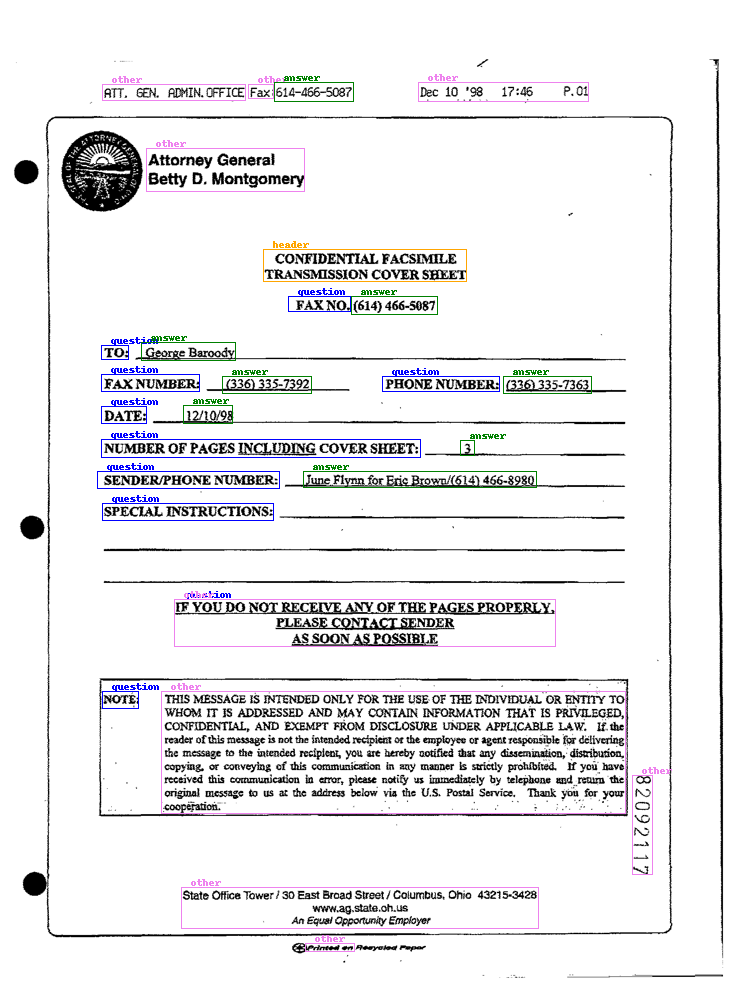

In [28]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
        return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

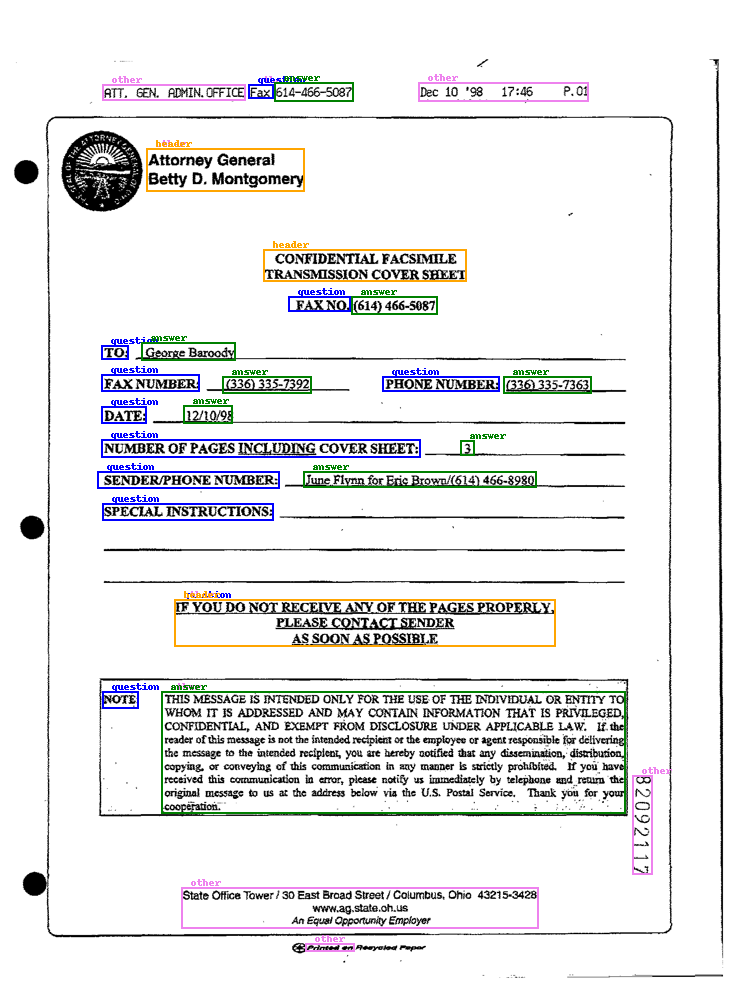

In [29]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
    actual_label = iob_to_label(id2label[label]).lower()
    box = unnormalize_box(box, width, height)
    draw.rectangle(box, outline=label2color[actual_label], width=2)
    draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image